## Visualize specific token based on activation results

### Define the data type (original or generated)

In [1]:
# data = "original"
data = "generated"

### Load the token dictory

In [2]:
import pickle
# 加载 pkl 文件，包含 npy 文件名到 token 索引列表的映射
if data == "generated":
    with open('/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/datasets/VQGAN_16384_generated_new/train_token_indices.pkl', 'rb') as f:
        token_dict = pickle.load(f)
elif data == "original":
    with open('/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/datasets/VQGAN_16384_original/train_token_indices.pkl', 'rb') as f:
        token_dict = pickle.load(f)

### Load the statistics data

In [ ]:
import csv
import torchvision.transforms.functional as TF

def load_top_tokens(csv_path, top_n, row_num):
    """
    从指定的csv文件中加载Top N的某一行token及其对应的文件列表。

    参数:
    csv_path (str): 要读取的csv文件路径。
    top_n (int): 要查询的Top N级别（如1, 5, 10, 20）。
    row_num (int): 要查询的行号（从1开始，排除表头）。

    返回:
    token (str): 对应的token索引。
    files (list): 对应的文件列表。
    """
    with open(csv_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        in_top_n_section = False
        current_row = 0

        for row in reader:
            # 检查是否到了Top N的部分
            if f"Top {top_n} Tokens" in row:
                in_top_n_section = True
                current_row = 0  # Reset the row count for this section
                continue

            # 如果到了Top N部分，开始读取指定行
            if in_top_n_section:
                if current_row == row_num:
                    token = row[0]  # 获取token索引
                    files = row[2].split('; ')  # 获取文件名列表，并按分号分割
                    return token, files
                current_row += 1

    return None, None  # 如果未找到，则返回None

def preprocess(img, target_image_size=256):
    s = min(img.size)
    if s < target_image_size:
        raise ValueError(f'Min dimension for image {s} < {target_image_size}')
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img


### Visualize the token in images

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch
import torchvision.transforms as T


# 提供要查找的特定 token
target_label = 498  # 替换为你要查找的token索引

# # 提供要处理的npy文件名列表

if data == "generated":
    csv_path = f"/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/results/Explanation/generated_data/label/Net1/label_activation_statistics/label_{target_label}.csv"
elif data == "original":
    csv_path = f"/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/results/Explanation/original_data/label/Net1/label_activation_statistics/label_{target_label}.csv"

top_n = 1  # 表示查找Top 1 Tokens
row_num =1  # 查找第1行的token及其文件列表

target_token, npy_file_list = load_top_tokens(csv_path, top_n, row_num)
target_token = int(target_token)
if target_token:
    print(f"Token: {target_token}")
    print(f"Files: {npy_file_list}")
else:
    print("Cannot find the specific token")

if data == "generated":
    # 原始图像存储路径
    image_base_path = '/data2/ty45972_data2/taming-transformers/datasets/imagenet_VQGAN_generated/'
elif data == "original":
    image_base_path = "/data2/ty45972_data2/taming-transformers/datasets/imagenet/train"

# 定义每个图像的token网格大小，假设为16x16
grid_size = 16
image_size = 256
patch_size = image_size // grid_size

def visualize_token_on_image(npy_filename, token_dict, target_token):
    # 提取子文件夹和图片名信息
    subfolder, image_name = npy_filename.split('_')
    image_name = image_name.replace('.npy', '.png')
    
    # 构建图像路径
    if data == "generated":
        image_path = os.path.join(image_base_path, subfolder, image_name)
    elif data == "original":
        image_path = os.path.join(image_base_path, subfolder, npy_filename.replace(".npy", ".JPEG"))
    
    print(f"Image path is {image_path}")
    # 检查文件是否存在
    if not os.path.exists(image_path):
        print(f"Image {image_path} does not exist.")
        return
    
    # 打开图像
    image = Image.open(image_path)
    if data == "original":
        processed_img = preprocess(image)
        processed_img_pil = Image.fromarray((processed_img.squeeze(0).permute(1, 2, 0).numpy() * 255).astype(np.uint8))
        image = processed_img_pil
    
    # 获取该文件对应的 token 列表
    token_list = token_dict.get(npy_filename)
    
    if token_list is None:
        print(f"No token list found for {npy_filename}.")
        return
    
    # 查找目标 token 的所有索引位置
    token_positions = [i for i, token in enumerate(token_list) if token == target_token]
    
    if not token_positions:
        print(f"Token {target_token} not found in {npy_filename}.")
        return
    
    # 在图像上绘制红色框，标注每个目标token的位置
    draw = ImageDraw.Draw(image)
    for token_position in token_positions:
        row = token_position // grid_size
        col = token_position % grid_size
        
        # 计算token在原图中的坐标
        left = col * patch_size
        upper = row * patch_size
        right = left + patch_size
        lower = upper + patch_size
        
        print(f"Token {target_token} position: {[left, upper, right, lower]}")
        # 在图像上绘制红色框
        draw.rectangle([left, upper, right, lower], outline="red", width=3)
    
    # 可视化图像
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Token {target_token} in {npy_filename}")
    plt.axis('off')
    plt.show()

# 遍历所有 npy 文件，进行可视化
for npy_file in npy_file_list:
    visualize_token_on_image(npy_file, token_dict, target_token)


### Concat images

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import torch
import torchvision.transforms as T


# 提供要查找的特定 token
target_label = 275  # 替换为你要查找的token索引

# # 提供要处理的npy文件名列表

if data == "generated":
    csv_path = f"/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/results/Explanation/generated_data/label/Net1/label_activation_statistics/label_{target_label}.csv"
elif data == "original":
    csv_path = f"/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/results/Explanation/original_data/label/Net1/label_activation_statistics/label_{target_label}.csv"

top_n = 1  # 表示查找Top 1 Tokens
row_num = 1 # 查找第1行的token及其文件列表

target_token, npy_file_list = load_top_tokens(csv_path, top_n, row_num)
target_token = int(target_token)
if target_token:
    print(f"Token: {target_token}")
    print(f"Files: {npy_file_list}")
else:
    print("Cannot find the specific token")

if data == "generated":
    # 原始图像存储路径
    image_base_path = '/data2/ty45972_data2/taming-transformers/datasets/imagenet_VQGAN_generated/'
elif data == "original":
    image_base_path = "/data2/ty45972_data2/taming-transformers/datasets/imagenet/train"

# 定义每个图像的token网格大小，假设为16x16
grid_size = 16
image_size = 256
patch_size = image_size // grid_size

def visualize_token_on_image(npy_filename, token_dict, target_token):
    # 提取子文件夹和图片名信息
    subfolder, image_name = npy_filename.split('_')
    image_name = image_name.replace('.npy', '.png')
    
    # 构建图像路径
    if data == "generated":
        image_path = os.path.join(image_base_path, subfolder, image_name)
    elif data == "original":
        image_path = os.path.join(image_base_path, subfolder, npy_filename.replace(".npy", ".JPEG"))
    
    print(f"Image path is {image_path}")
    # 检查文件是否存在
    if not os.path.exists(image_path):
        print(f"Image {image_path} does not exist.")
        return
    
    # 打开图像
    image = Image.open(image_path)
    if data == "original":
        processed_img = preprocess(image)
        processed_img_pil = Image.fromarray((processed_img.squeeze(0).permute(1, 2, 0).numpy() * 255).astype(np.uint8))
        image = processed_img_pil
    
    # 获取该文件对应的 token 列表
    token_list = token_dict.get(npy_filename)
    
    if token_list is None:
        print(f"No token list found for {npy_filename}.")
        return
    
    # 查找目标 token 的所有索引位置
    token_positions = [i for i, token in enumerate(token_list) if token == target_token]
    
    if not token_positions:
        print(f"Token {target_token} not found in {npy_filename}.")
        return
    
    # 在图像上绘制红色框，标注每个目标token的位置
    draw = ImageDraw.Draw(image)
    for token_position in token_positions:
        row = token_position // grid_size
        col = token_position % grid_size
        
        # 计算token在原图中的坐标
        left = col * patch_size
        upper = row * patch_size
        right = left + patch_size
        lower = upper + patch_size
        
        print(f"Token {target_token} position: {[left, upper, right, lower]}")
        # 在图像上绘制红色框
        draw.rectangle([left, upper, right, lower], outline="red", width=3)
    
    # 返回标记后的图像
    return image

def combine_images(image_list, num_cols=3):
    num_images = len(image_list)
    num_rows = (num_images + num_cols - 1) // num_cols  # 计算需要多少行
    img_width, img_height = image_list[0].size  # 获取单个图像的尺寸
    combined_img = Image.new('RGB', (img_width * num_cols, img_height * num_rows))  # 创建空白大图
    
    for idx, img in enumerate(image_list):
        row = idx // num_cols
        col = idx % num_cols
        combined_img.paste(img, (col * img_width, row * img_height))  # 将每张图按顺序粘贴到大图中
    
    return combined_img

# 遍历所有 npy 文件，每六张图拼接为一张大图并保存
image_list = []
image_counter = 1  # 计数器，跟踪生成的拼接图的数量
save_dir = f"/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/results/Explanation/visualization_results/{data}"
os.makedirs(save_dir, exist_ok=True)  # 确保保存目录存在

for npy_file in npy_file_list:
    img = visualize_token_on_image(npy_file, token_dict, target_token)
    if img:
        image_list.append(img)
    if len(image_list) == 6:
        combined_img = combine_images(image_list)
        
        # 构造文件保存路径，加入计数器以避免重复
        save_path = os.path.join(save_dir, f"{target_label}_top_{top_n}_row_{row_num}_part_{image_counter}.png")
        
        # 显示拼接图
        plt.figure(figsize=(12, 8))  # 调整图像的显示大小
        plt.imshow(combined_img)
        plt.title(f"Token {target_token} in label {target_label}")
        
        # 保存拼接后的大图，连同标题一起保存
        plt.axis('off')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)  # 保存带标题的图片
        print(f"Saved combined image: {save_path}")
        plt.show()
        
        image_counter += 1  # 递增计数器
        image_list = []  # 清空列表，准备下一批图像

# 处理剩下的图像（少于6张的情况）
if image_list:
    combined_img = combine_images(image_list)
    save_path = os.path.join(save_dir, f"{target_label}_top_{top_n}_row_{row_num}_part_{image_counter}.png")

    # 显示拼接图
    plt.figure(figsize=(12, 8))
    plt.imshow(combined_img)
    plt.title(f"Token {target_token} in label {target_label}")
    
    # 保存拼接后的大图，连同标题一起保存
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)  # 保存带标题的图片
    print(f"Saved combined image: {save_path}")
    plt.show()


### Test the image classification model

target token list is 100
1000
target token list is [1962, 134, 1702, 15630, 15771, 1847, 7752, 5984, 1024, 8131, 5542, 4967, 5666, 15383, 2891, 91, 1598, 6764, 11574, 8322, 3547, 5605, 1994, 3809, 13810, 13037, 15111, 1663, 15891, 8770, 7465, 9656, 5068, 2959, 8111, 9514, 9186, 5107, 1274, 9212, 15265, 9502, 6945, 9390, 1711, 5418, 13293, 15883, 14878, 10639, 142, 2325, 14140, 8382, 6348, 14450, 10228, 1497, 7482, 14102, 689, 11326, 3708, 10689, 15331, 1069, 2214, 8566, 598, 5900, 11211, 7020, 1008, 1495, 14531, 7701, 9000, 6879, 8717, 15702, 5651, 14225, 1721, 2635, 468, 11587, 6018, 6242, 1258, 3001, 11904, 12016, 2273, 15695, 4203, 6790, 3915, 8225, 2428, 652]
Image path is /data2/ty45972_data2/taming-transformers/datasets/imagenet_VQGAN_generated/498/000000.png


NameError: name 'target_token' is not defined

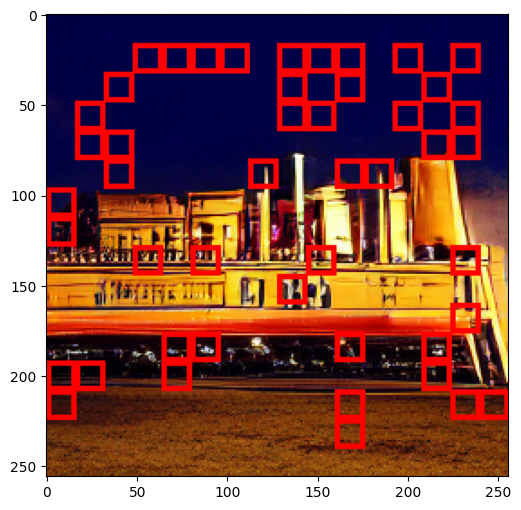

In [19]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import csv
import torch
import torchvision.transforms as T

import csv
import torchvision.transforms.functional as TF


import pickle

data = "generated"



def load_top_tokens(csv_path, top_n):
    target_token_list = []
    """
    从指定的csv文件中加载Top N的某一行token及其对应的文件列表。

    参数:
    csv_path (str): 要读取的csv文件路径。
    top_n (int): 要查询的Top N级别（如1, 5, 10, 20）。
    row_num (int): 要查询的行号（从1开始，排除表头）。

    返回:
    token (str): 对应的token索引。
    files (list): 对应的文件列表。
    """
    with open(csv_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        in_top_n_section = False
        current_row = 0

        for row in reader:
            # 检查是否到了Top N的部分
            if f"Top {top_n} Tokens" in row:
                in_top_n_section = True
                next(reader)
                continue

            # 如果到了Top N部分，开始读取指定行
            if in_top_n_section:
                if "Top" in row[0]:
                    break
                token = int(row[0])  # 获取token索引
                files = row[2].split('; ')  # 获取文件名列表，并按分号分割
                target_token_list.append(token)


    return target_token_list  # 如果未找到，则返回None


# 提供要查找的特定 token
target_label = 498  # 替换为你要查找的token索引

# # 提供要处理的npy文件名列表

if data == "generated":
    csv_path = f"/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/results/Explanation/generated_data/label/Net1/label_activation_statistics/label_{target_label}.csv"
elif data == "original":
    csv_path = f"/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/results/Explanation/original_data/label/Net1/label_activation_statistics/label_{target_label}.csv"

top_n = 5  # 表示查找Top n Tokens
row_num =1  # 查找第1行的token及其文件列表


target_token_list = load_top_tokens(csv_path, top_n)
if target_token_list:
    print(f"target token list is {len(target_token_list)}")
else:
    print("Cannot find the specific token")



if data == "generated":
    # 原始图像存储路径
    activation_results_path = f"/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/results/Explanation/generated_data/label/Net1/label_activation_results/label_{target_label}.csv"
    image_base_path = '/data2/ty45972_data2/taming-transformers/datasets/imagenet_VQGAN_generated/'
    with open('/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/datasets/VQGAN_16384_generated_new/train_token_indices.pkl', 'rb') as f:
        token_dict = pickle.load(f)
elif data == "original":
    activation_results_path = f"/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/results/Explanation/original_data/label/Net1/label_activation_results/label_{target_label}.csv"
    image_base_path = "/data2/ty45972_data2/taming-transformers/datasets/imagenet/train"
    with open('/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/datasets/VQGAN_16384_original/train_token_indices.pkl', 'rb') as f:
        token_dict = pickle.load(f)


npy_file_list = []

with open(activation_results_path, 'r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        npy_file_list.append(row['filename'])

print(len(npy_file_list))

# 定义每个图像的token网格大小，假设为16x16
grid_size = 16
image_size = 256
patch_size = image_size // grid_size

def visualize_token_on_image(npy_filename, token_dict, target_token_list):
    # 提取子文件夹和图片名信息
    subfolder, image_name = npy_filename.split('_')
    image_name = image_name.replace('.npy', '.png')
    
    # 构建图像路径
    if data == "generated":
        image_path = os.path.join(image_base_path, subfolder, image_name)
    elif data == "original":
        image_path = os.path.join(image_base_path, subfolder, npy_filename.replace(".npy", ".JPEG"))
    
    print(f"Image path is {image_path}")
    # 检查文件是否存在
    if not os.path.exists(image_path):
        print(f"Image {image_path} does not exist.")
        return
    
    # 打开图像
    image = Image.open(image_path)
    if data == "original":
        processed_img = preprocess(image)
        processed_img_pil = Image.fromarray((processed_img.squeeze(0).permute(1, 2, 0).numpy() * 255).astype(np.uint8))
        image = processed_img_pil
    
    # 获取该文件对应的 token 列表
    token_list = token_dict.get(npy_filename)
    
    if token_list is None:
        print(f"No token list found for {npy_filename}.")
        return
    
    # 查找目标 token 的所有索引位置
    token_positions = [i for i, token in enumerate(token_list) if token in target_token_list]
    
    if not token_positions:
        print(f"Token {target_token} not found in {npy_filename}.")
        return
    
    # 在图像上绘制红色框，标注每个目标token的位置
    draw = ImageDraw.Draw(image)
    for token_position in token_positions:
        row = token_position // grid_size
        col = token_position % grid_size
        
        # 计算token在原图中的坐标
        left = col * patch_size
        upper = row * patch_size
        right = left + patch_size
        lower = upper + patch_size
        
        # 在图像上绘制红色框
        draw.rectangle([left, upper, right, lower], outline="red", width=3)
    
    # 可视化图像
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"token list")
    plt.axis('off')
    plt.show()

# 遍历所有 npy 文件，进行可视化
print(f"target token list is {target_token_list}")
for npy_file in npy_file_list:
    visualize_token_on_image(npy_file, token_dict, target_token_list)
